# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import time
import copy

from minot.ClusterTools import map_tools
import pitszi

# Parameters

In [2]:
output_dir = '/Users/adam/Desktop/pitszi/'

In [3]:
#----- Physical model parameters
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec   = 30*u.deg, 55*u.deg
dRA, dDec = 80*u.arcsec, -25*u.arcsec
axis_q1, axis_q2 = 0.7, 0.7
euler_1, euler_2, euler_3 = 0*u.deg, 90*u.deg, 35*u.deg

fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_seed = int(np.random.uniform(0,100000))

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM1 = 18*u.arcsec
beam_FWHM2 = 1.8*u.arcsec

# Transfer function
karcsec1 = np.linspace(0, 1/beam_FWHM1.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov1 = 1/(7*60)
TF1 = {'k':karcsec1, 'TF':1-np.exp(-karcsec1.to_value('arcsec-1')/kfov1)}
karcsec2 = np.linspace(0, 1/beam_FWHM2.to_value('arcsec')*10, 1000)*u.arcsec**-1
kfov2 = 1/(0.7*60)
TF2 = {'k':karcsec2, 'TF':1-np.exp(-karcsec2.to_value('arcsec-1')/kfov2)}

# Mask
mask_Ntheta500 = 1

# Noise
noise_k1 = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)
noise_r1 = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))
noise_k2 = lambda k_arcsec: (2e-9 + 2e-9 * (k_arcsec*60)**-1)/5
noise_r2 = lambda r_arcsec: (1 + np.exp((r_arcsec-100)/40))

In [5]:
#----- Analysis parameters
# Image sampling
los_size = 1*u.Mpc
los_reso = 100*u.kpc

# Pk measurement
Nbins_pk = 30
scale_bins = 'lin'
kmin_pk = 1/(60*5)*u.arcsec**-1
kmax_pk = 1/(beam_FWHM1.to('arcsec'))

# weight definition
method_w8_radial  = True
method_w8_smooth  = 20*u.arcsec
method_w8_beam    = True
method_w8_TF      = False

# methodology
method_data_deconv = False
method_use_covmat  = False
method_parallel    = False

# MCMC
nwalkers = 20
nsteps = 500
burnin = 200
mcmc_reset = True
mcmc_run = True
mcmc_Nresamp = 100

# Generate mock data

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA+dRA, Dec=Dec+dDec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'statistics':'gaussian',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}

mock.map_center = SkyCoord(RA, Dec, frame="icrs")
mock.map_fov    = [6, 4]*u.arcmin
mock.map_reso  = 5*u.arcsec
mock.los_reso  = los_reso
mock.los_size  = los_size
mock.R_truncation = mock.R500*10

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 73 , 49 , 11
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   2295.2   ,   1540.6   ] kpc ; [   6.083    ,   4.083    ] arcmin
   L.o.S. resolution :        100.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.002740  /  0.098630   1/arcsec
   k min/max projected :       0.000436  /  0.015685   1/kpc
   k min/max L.o.S. (eq.) :    0.005717  /  0.028583   1/arcsec
   k min/max L.o.S. :          0.000909  /  0.004545   1/kpc
   k max Nyquist :             0.028583   1/arcsec
   k max Nyquist :             0.004545   1/kpc


In [7]:
#===== Define the mask
ramap, decmap = map_tools.get_radec_map(mock.get_map_header())
dist_map = map_tools.greatcircle(ramap, decmap, (RA+dRA).to_value('deg'), (Dec+dDec).to_value('deg'))
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 

In [8]:
#===== Initiate a data object and fake data
#----- Init with the mock
data1 = pitszi.Data(mock.get_sz_map(), mock.get_map_header(), 
                    psf_fwhm=beam_FWHM1,transfer_function=TF1, noise_model=[noise_r1, noise_k1], mask=mask,
                    output_dir=output_dir, silent=True)
data2 = pitszi.Data(mock.get_sz_map(), mock.get_map_header(), 
                    psf_fwhm=beam_FWHM2,transfer_function=TF2, noise_model=[noise_r2, noise_k2], mask=mask,
                    output_dir=output_dir, silent=True)

#----- Define the noise properties
data1.noise_mc = data1.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.map_center)
data1.noise_rms = data1.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)

data2.noise_mc = data2.get_noise_monte_carlo_from_model(Nmc=1000, center=mock.map_center)
data2.noise_rms = data2.get_noise_rms_from_model(Nmc=1000, center=mock.map_center)

#----- Mock the data
img1 = data1.set_image_to_mock(mock, model_seed=fluct_seed, model_no_fluctuations=False, 
                               noise_origin='model', noise_center=mock.map_center)
img2 = data2.set_image_to_mock(mock, model_seed=fluct_seed, model_no_fluctuations=False, 
                               noise_origin='model', noise_center=mock.map_center)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in reciprocal
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in reciprocal


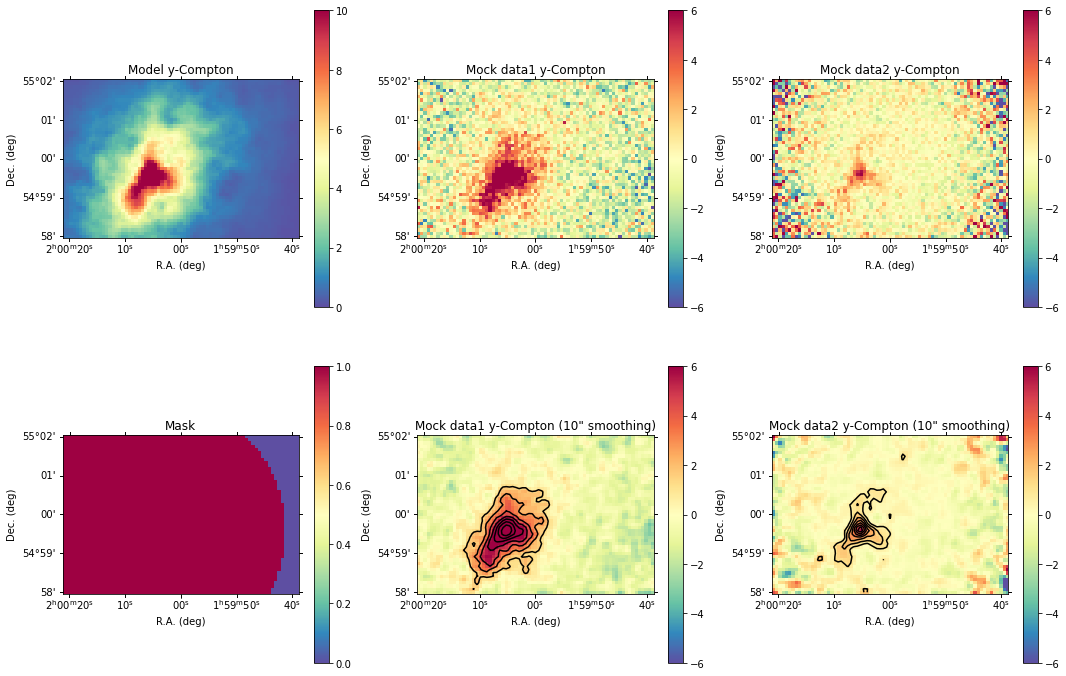

In [9]:
visu_smooth = 10

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 12))

ax = plt.subplot(2, 3, 1, projection=WCS(mock.get_map_header()))
plt.imshow(mock.get_sz_map(seed=fluct_seed, no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 2, projection=WCS(data1.header))
plt.imshow(data1.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data1 y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 3, projection=WCS(data2.header))
plt.imshow(data2.image*1e5, cmap='Spectral_r',vmin=-6, vmax=6)
cb = plt.colorbar()
plt.title('Mock data2 y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 4, projection=WCS(data1.header))
plt.imshow(data1.mask, cmap='Spectral_r', vmin=0, vmax=1)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 5, projection=WCS(data1.header))
plt.imshow(gaussian_filter(data1.image, sigma=visu_smooth/2.35/data1.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data1.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data1.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data1.image, sigma=visu_smooth/2.35/data1.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data1 y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(2,3, 6, projection=WCS(data2.header))
plt.imshow(gaussian_filter(data2.image, sigma=visu_smooth/2.35/data2.header['CDELT2']/3600)*1e5, cmap='Spectral_r', vmin=-6, vmax=6)
cb = plt.colorbar()
rms = np.std(gaussian_filter(data2.noise_mc, sigma=np.array([0,1,1])*visu_smooth/2.35/data2.header['CDELT2']/3600), axis=0)
plt.contour(gaussian_filter(data2.image, sigma=visu_smooth/2.35/data2.header['CDELT2']/3600)/rms, levels=[3,6,9,12,15,18,21], colors='k')
plt.title('Mock data2 y-Compton ('+str(int(visu_smooth))+'" smoothing)')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

In [10]:
model = copy.deepcopy(mock)

# Radial profile constraints

In [11]:
RadInf1 = pitszi.InferenceRadial(data1, model, 
                                 method_use_covmat=method_use_covmat,method_parallel=method_parallel,
                                 mcmc_nwalkers=nwalkers,mcmc_nsteps=nsteps,mcmc_burnin=burnin,
                                 mcmc_reset=mcmc_reset,mcmc_run=mcmc_run,
                                 mcmc_Nresamp=mcmc_Nresamp,
                                 output_dir=output_dir, silent=True)
RadInf2 = pitszi.InferenceRadial(data2, model, 
                                 method_use_covmat=method_use_covmat,method_parallel=method_parallel,
                                 mcmc_nwalkers=nwalkers,mcmc_nsteps=nsteps,mcmc_burnin=burnin,
                                 mcmc_reset=mcmc_reset,mcmc_run=mcmc_run,
                                 mcmc_Nresamp=mcmc_Nresamp,
                                 output_dir=output_dir, silent=True)

In [12]:
fitpar_prof = {
    #'P_0': {'guess':[0.02, 0.001], 'unit': u.keV*u.cm**-3, 'limit':[0, np.inf]},
    #'r_p': {'guess':[1000, 1000], 'unit': u.kpc, 'limit':[0, np.inf]},
    #'a': {'guess':[1, 0.5], 'unit': None, 'limit':[0, 10]},
    #'b': {'guess':[5, 0.5], 'unit': None, 'limit':[0, 10]},
    #'c': {'guess':[0.5, 0.5], 'unit': None, 'limit':[-1, 3]},
    'M500':{'guess':[10,1], 'unit':1e14*u.Msun, 'limit':[1, 100], 'P_ref':'A10MD'},
    #'min_to_maj_axis_ratio':{'guess':[1,0.1], 'unit':None, 'limit':[0,1]}, 
    #'angle':{'guess':[0,90], 'unit':u.deg, 'limit':[-90,90]},
    #'RA': {'guess':[RA.to_value('arcmin'), 1], 'unit': u.arcmin, 'limit':[RA.to_value('arcmin')-1, RA.to_value('arcmin')+1]},
    #'Dec': {'guess':[Dec.to_value('arcmin'), 1], 'unit': u.arcmin, 'limit':[Dec.to_value('arcmin')-1, Dec.to_value('arcmin')+1]},
    'ZL':{'guess':[0,1e-5],'unit':None},
              }

In [13]:
Pname, Popt1, Pcov1 = RadInf1.run_curvefit_profile(fitpar_prof, show_fit_result=True, set_bestfit=True)
Pname, Popt2, Pcov2 = RadInf2.run_curvefit_profile(fitpar_prof, show_fit_result=True, set_bestfit=True)

param 0 (M500): 
   median   = 11.287061917654169 -0.13649871829408156 +0.13494781153182878
   best-fit = 11.28816407302535 -0.13760087366526186 +0.13384565616064847
   M500 = 11.287061917654169_{-0.13649871829408156}^{0.13494781153182878}
param 1 (ZL): 
   median   = -3.4821929614151365e-07 -2.4128794576497745e-07 +2.490333130960188e-07
   best-fit = -1.6837083447403482e-07 -4.211364074324563e-07 +6.918485142854e-08
   ZL = -3.4821929614151365e-07_{-2.4128794576497745e-07}^{2.490333130960188e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


param 0 (M500): 
   median   = 13.96718324233282 -0.3938952960589983 +0.39599374330948933
   best-fit = 13.969514903121452 -0.3962269568476291 +0.39366208252085855
   M500 = 13.96718324233282_{-0.3938952960589983}^{0.39599374330948933}
param 1 (ZL): 
   median   = -6.861691245280036e-07 -1.816757530132385e-07 +1.7737453523065506e-07
   best-fit = -7.211266818482552e-07 -1.4671819569298693e-07 +2.1233209255090664e-07
   ZL = -6.861691245280036e-07_{-1.816757530132385e-07}^{1.7737453523065506e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


In [14]:
Pname, samp1 = RadInf1.run_mcmc_profile(fitpar_prof, show_fit_result=True, set_bestfit=True)
Pname, samp2 = RadInf2.run_mcmc_profile(fitpar_prof, show_fit_result=True, set_bestfit=True)

----- Existing sampler:
      /Users/adam/Desktop/pitszi//pitszi_MCMC_Profile_sampler.h5
----- Does the sampler already exist? -----
      - Yes, but reset the MCMC even though the sampler already exists


100%|██████████| 500/500 [04:13<00:00,  1.97it/s]


param 0 (M500): 
   median   = 11.28456581890945 -0.13483440736161612 +0.13362999467632086
   best-fit = 11.291582083520668 -0.14185067197283452 +0.12661373006510246
   M500 = 11.28456581890945_{-0.13483440736161612}^{0.13362999467632086}
param 1 (ZL): 
   median   = -3.3056543293998526e-07 -2.3656926966226547e-07 +2.480997563302801e-07
   best-fit = -3.4813332572148464e-07 -2.190013768807661e-07 +2.6566764911177946e-07
   ZL = -3.3056543293998526e-07_{-2.3656926966226547e-07}^{2.480997563302801e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


----- Existing sampler:
      /Users/adam/Desktop/pitszi//pitszi_MCMC_Profile_sampler.h5
----- Does the sampler already exist? -----
      - Yes, but reset the MCMC even though the sampler already exists


100%|██████████| 500/500 [03:52<00:00,  2.15it/s]


param 0 (M500): 
   median   = 13.993777007647658 -0.3966481079251185 +0.3832627633973331
   best-fit = 13.960309305766849 -0.3631804060443091 +0.4167304652781425
   M500 = 13.993777007647658_{-0.3966481079251185}^{0.3832627633973331}
param 1 (ZL): 
   median   = -6.909109323462199e-07 -1.8031994055388015e-07 +1.8328280473099144e-07
   best-fit = -6.843212315942212e-07 -1.8690964130587884e-07 +1.7669310397899275e-07
   ZL = -6.909109323462199e-07_{-1.8031994055388015e-07}^{1.8328280473099144e-07}


/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


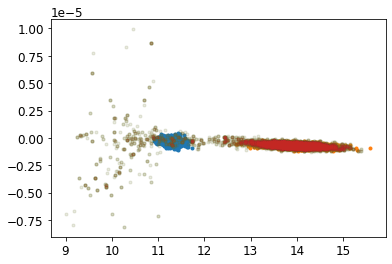

In [15]:
Nsample = 1000
par_chains1 = np.zeros((Nsample, len(fitpar_prof)))
par_chains2 = np.zeros((Nsample, len(fitpar_prof)))

for isamp in range(Nsample):
    par_chains1[isamp,:] = np.random.multivariate_normal(Popt1, Pcov1)
    par_chains2[isamp,:] = np.random.multivariate_normal(Popt2, Pcov2)

plt.plot(par_chains1[:,0], par_chains1[:,1], marker='.', ls='')
plt.plot(par_chains2[:,0], par_chains2[:,1], marker='.', ls='')
plt.plot(samp1.flatchain[:,0], samp1.flatchain[:,1], marker='.', ls='', alpha=0.1)
plt.plot(samp2.flatchain[:,0], samp2.flatchain[:,1], marker='.', ls='', alpha=0.05)

# Pk constraints

In [16]:
method_use_covmat = True

In [17]:
#===== Define the ROI
Rroi = 1.5 # arcmin
ramap, decmap = map_tools.get_radec_map(mock.get_map_header())
dist_map = map_tools.greatcircle(ramap, decmap, (RA+dRA).to_value('deg'), (Dec+dDec).to_value('deg'))
roi = dist_map * 0 + 1
roi[dist_map > Rroi/60] = 0 

### Single spectra

In [18]:
FlucInf1 = pitszi.InferenceFluctuation(data1, model, 
                                       method_use_covmat=method_use_covmat, method_parallel=method_parallel, method_data_deconv=method_data_deconv,
                                       kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                       mcmc_nwalkers=nwalkers,mcmc_nsteps=nsteps,mcmc_burnin=burnin,
                                       mcmc_reset=mcmc_reset,mcmc_run=mcmc_run,
                                       mcmc_Nresamp=mcmc_Nresamp,
                                       output_dir=output_dir, silent=False)

FlucInf1.set_method_w8(roi_mask=roi,
                       apply_radial_model=method_w8_radial, 
                       conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                       remove_GNFW_core=True, smooth_FWHM=method_w8_smooth)

FlucInf1.pk_setup()

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [ 6.  2.  8. 12. 10. 16.  8. 24. 12. 20. 22. 16. 32. 26. 22. 34. 32. 36.
 26. 42. 38. 44. 36. 44. 50. 40. 56. 38. 62. 54.]
      - Minimal count in k bins: 2.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing


In [19]:
FlucInf2 = pitszi.InferenceFluctuation(data2, model, 
                                       method_use_covmat=method_use_covmat, method_parallel=method_parallel, method_data_deconv=method_data_deconv,
                                       kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                       mcmc_nwalkers=nwalkers,mcmc_nsteps=nsteps,mcmc_burnin=burnin,
                                       mcmc_reset=mcmc_reset,mcmc_run=mcmc_run,
                                       mcmc_Nresamp=mcmc_Nresamp,
                                       output_dir=output_dir, silent=True)

FlucInf2.set_method_w8(roi_mask=roi,
                       apply_radial_model=method_w8_radial, 
                       conv_radial_model_beam=method_w8_beam, conv_radial_model_TF=method_w8_TF, 
                       remove_GNFW_core=True, smooth_FWHM=method_w8_smooth)

FlucInf2.pk_setup()

In [20]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

In [21]:
Pname, Popt1, Pcov1 = FlucInf1.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)
Pname, Popt2, Pcov2 = FlucInf2.run_curvefit_fluctuation(fitpar_pk3d, show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
param 0 (Norm): 
   median   = 0.614648434912723 -0.02456085376344541 +0.025275191019489718
   best-fit = 0.6271640462162724 -0.0370764650669948 +0.012759579715940328
   Norm = 0.614648434912723_{-0.02456085376344541}^{0.025275191019489718}
param 1 (Linj): 
   median   = 607.3910255419426 -22.919735539953535 +22.652017796515793
   best-fit = 607.0479694973701 -22.576679495381086 +22.995073841088242
   Linj = 607.3910255419426_{-22.919735539953535}^{22.652017796515793}
param 2 (Anoise): 
   median   = 1.1183930577888876 -0.08869764272656999 +0.09065077171739011
   best-fit = 1.1215297108641429 -0.09183429580182523 +0.08751411864213487
   Anoise = 1.1183930577888876_{-0.08869764272656999}^{0.09065077171739011}
----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct an

In [22]:
Pname, samp1 = FlucInf1.run_mcmc_fluctuation(fitpar_pk3d, kind='projection', show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/adam/Desktop/pitszi//pitszi_MCMC_Fluctuation_projection_sampler.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj' 'Anoise']
      - Starting point mean:          
[5.e-01 8.e+02 1.e+00]
      - Starting point dispersion :   
[5.e-01 5.e+02 2.e-01]
      - Minimal starting point:       
[  0 100   0]
      - Maximal starting point:       
[   3 3000    2]
      - Number of dimensions:         
3
      - Parallel mode:                
False
      - Use covariance matrix?        
True
-----
----- Does the sampler already exist? -----
      - Yes, but reset the MCMC even though the sampler already exists
----- MCMC sampling -----
      - Runing 500 MCMC steps


100%|██████████| 500/500 [15:27<00:00,  1.85s/it]


param 0 (Norm): 
   median   = 0.6109175417216668 -0.04064992582250304 +0.03706591749589472
   best-fit = 0.6144856771359664 -0.04421806123680261 +0.03349778208159515
   Norm = 0.6109175417216668_{-0.04064992582250304}^{0.03706591749589472}
param 1 (Linj): 
   median   = 611.4892729235594 -39.204705991297715 +48.78202209778715
   best-fit = 607.1233680565845 -34.8388011243228 +53.147926964762064
   Linj = 611.4892729235594_{-39.204705991297715}^{48.78202209778715}
param 2 (Anoise): 
   median   = 1.1148115712813882 -0.10482314205214593 +0.09057419354344276
   best-fit = 1.1167929268315329 -0.1068044976022906 +0.08859283799329809
   Anoise = 1.1148115712813882_{-0.10482314205214593}^{0.09057419354344276}


In [23]:
Pname, samp2 = FlucInf2.run_mcmc_fluctuation(fitpar_pk3d, kind='projection', show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/adam/Desktop/pitszi//pitszi_MCMC_Fluctuation_projection_sampler.h5
----- Does the sampler already exist? -----
      - Yes, but reset the MCMC even though the sampler already exists


100%|██████████| 500/500 [14:01<00:00,  1.68s/it]


param 0 (Norm): 
   median   = 0.9108660858013358 -0.03076523488362415 +0.025951076120957817
   best-fit = 0.9323888522794181 -0.052288001361706526 +0.004428309642875439
   Norm = 0.9108660858013358_{-0.03076523488362415}^{0.025951076120957817}
param 1 (Linj): 
   median   = 429.9423709835082 -18.857086028180333 +19.424430714857294
   best-fit = 422.0341600526676 -10.94887509733968 +27.332641645697947
   Linj = 429.9423709835082_{-18.857086028180333}^{19.424430714857294}
param 2 (Anoise): 
   median   = 0.12156901718117996 -0.08289958070881717 +0.12271350335155767
   best-fit = 0.012322875134584535 --0.026346561337778254 +0.2319596453981531
   Anoise = 0.12156901718117996_{-0.08289958070881717}^{0.12271350335155767}


### Cross spectra

In [28]:
FlucInfX = pitszi.InferenceFluctuation(data1, model, data2=data2,
                                       method_use_covmat=method_use_covmat, 
                                       method_parallel=method_parallel, 
                                       method_data_deconv=method_data_deconv,
                                       kbin_min=kmin_pk, kbin_max=kmax_pk, kbin_Nbin=Nbins_pk, kbin_scale=scale_bins,
                                       mcmc_nwalkers=nwalkers,mcmc_nsteps=nsteps,mcmc_burnin=burnin,mcmc_reset=mcmc_reset,mcmc_run=mcmc_run,mcmc_Nresamp=mcmc_Nresamp,
                                       output_dir=output_dir, silent=True)

FlucInfX.set_method_w8(roi_mask=roi,
                       apply_radial_model=method_w8_radial, 
                       conv_radial_model_beam=method_w8_beam, 
                       conv_radial_model_TF=method_w8_TF, 
                       remove_GNFW_core=True, 
                       smooth_FWHM=method_w8_smooth)

FlucInfX.pk_setup()

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [ 6.  2.  8. 12. 10. 16.  8. 24. 12. 20. 22. 16. 32. 26. 22. 34. 32. 36.
 26. 42. 38. 44. 36. 44. 50. 40. 56. 38. 62. 54.]
      - Minimal count in k bins: 2.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing


In [29]:
unit = 'kpc'
if unit == 'arcsec':
    phys=False
if unit == 'kpc':
    phys=True
    
k2d, pk2d_data = FlucInfX.get_pk2d_data(physical=phys)
k2d, pk2d_noise, pk2d_noisecovmat = FlucInfX.get_pk2d_noise_statistics(physical=phys)
k2d, pk2d_modref, pk2d_modcovmat = FlucInfX.get_pk2d_model_statistics(physical=phys, Nmc=100)

k2d, pk2d_test_modbrute  = FlucInfX.get_pk2d_model_brute(physical=phys)
k2d, pk2d_test_moddeproj = FlucInfX.get_pk2d_model_proj(physical=phys)

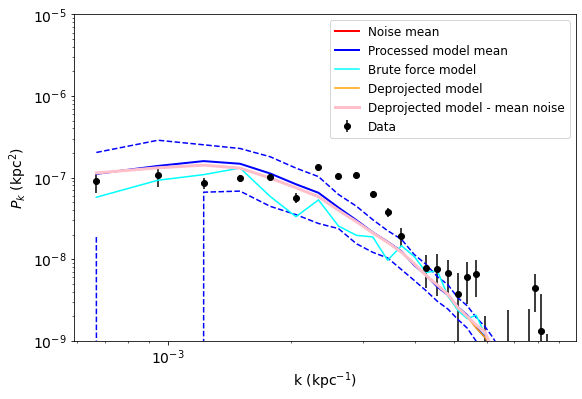

In [30]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(0, figsize=(9, 6))

plt.errorbar(k2d.to_value(unit+'-1'), pk2d_data.to_value(unit+'2'), 
             np.diag(pk2d_noisecovmat.to_value(unit+'4'))**0.5, marker='o', ls='', color='k', label='Data')
plt.plot(k2d.to_value(unit+'-1'), pk2d_noise.to_value(unit+'2'), color='red', lw=2, label='Noise mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2'), color='blue', lw=2, label='Processed model mean')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') + np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_modref.to_value(unit+'2') - np.diag(pk2d_modcovmat.to_value(unit+'4'))**0.5, color='blue', ls='--')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_modbrute.to_value(unit+'2'), color='cyan', label='Brute force model')
plt.plot(k2d.to_value(unit+'-1'), pk2d_test_moddeproj.to_value(unit+'2'), color='orange', label='Deprojected model')
plt.plot(k2d.to_value(unit+'-1'), (pk2d_test_moddeproj-pk2d_noise).to_value(unit+'2'), color='pink', lw=3, label='Deprojected model - mean noise')
plt.xscale('log')
plt.yscale('log')
plt.ylim(np.amax(pk2d_data.to_value(unit+'2'))*5e-3, np.amax(pk2d_data.to_value(unit+'2'))*1.5)
plt.ylim(1e-9,1e-5)
plt.xlabel('k ('+unit+'$^{-1}$)')
plt.ylabel(r'$P_k$ ('+unit+'$^{2}$)')
plt.legend(fontsize=12)

In [31]:
fitpar_pk3d = {
    'Norm':{'guess':[0.5, 0.5],'unit': None,'limit':[0, 3]}, #'prior':[0.5, 0.2],},
    #'slope':{'guess':[-11/3, 0.5],'unit': None,'limit':[-11/3-2, -11/3+2]}, #, #'prior':[-11/3, 0.5],},
    'Linj':{'guess':[800, 500],'unit': u.kpc,'limit':[100, 3000]}, #, 'prior':[600, 300],      
    #'Anoise':{'guess':[1, 0.2],'unit': None,'limit':[0, 2]},
              }

In [32]:
FlucInfX.nuisance_Anoise = 0

In [34]:
Pname, sampX = FlucInfX.run_mcmc_fluctuation(fitpar_pk3d, kind='projection', show_fit_result=True)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
----- Existing sampler:
      /Users/adam/Desktop/pitszi//pitszi_MCMC_Fluctuation_projection_sampler.h5
----- Fit parameters information -----
      - Fitted parameters:            
['Norm' 'Linj']
      - Starting point mean:          
[5.e-01 8.e+02]
      - Starting point dispersion :   
[  0.5 500. ]
      - Minimal starting point:       
[  0 100]
      - Maximal starting point:       
[   3 3000]
      - Number of dimensions:         
2
      - Parallel mode:                
False
      - Use covariance matrix?        
True
-----
----- Does the sampler already exist? -----
      - Yes, but reset the MCMC even though the sampler already exists
----- MCMC sampling -----
      - Runing 500 MCMC steps


100%|██████████| 500/500 [17:57<00:00,  2.16s/it]


param 0 (Norm): 
   median   = 0.7890205424514295 -0.02812485833763989 +0.02580608960123265
   best-fit = 0.7890837757742958 -0.028188091660506176 +0.025742856278366366
   Norm = 0.7890205424514295_{-0.02812485833763989}^{0.02580608960123265}
param 1 (Linj): 
   median   = 429.0543836746383 -14.096315617446237 +16.34236416622832
   best-fit = 430.44462520602957 -15.486557148837505 +14.952122634837053
   Linj = 429.0543836746383_{-14.096315617446237}^{16.34236416622832}


/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:860: RuntimeWarning: invalid value encountered in sqrt
  err_tot = np.sqrt(2*np.pi*k2d**2)/(2*np.sqrt(pk2d_data))*(pk2d_data_err_model**2+pk2d_data_err_noise**2)**0.5
/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:861: RuntimeWarning: invalid value encountered in sqrt
  err_noise = np.sqrt(2*np.pi*k2d**2)/(2*np.sqrt(pk2d_data))*pk2d_data_err_noise
/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:867: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(k2d, np.sqrt(2*np.pi*k2d**2*pk2d_data), err_tot, marker='o', ls='', color='grey',
/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/pitszi/utils_plot.py:869: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(k2d, np.sqrt(2*np.pi*k2d**2*pk2d_data), err_noise, marker='o', ls='', color='k',
/Users/adam/Project/NIKA/Software/Processing/Labtools/